# Encoder Decoder Architecture (Seq-Seq)
The encoder-decoder architecture is a neural network design used for sequence-to-sequence tasks such as machine translation, text summarization, and text cleaning. It consists of two main components: the **encoder** and the **decoder**.

The **encoder** processes the input sequence (e.g., a noisy sentence) and compresses its information into a fixed-length context vector. This is typically done using Recurrent Neural Networks (RNNs) like LSTM or GRU. The encoder reads each word of the input sequence one at a time and updates its hidden state to capture the sentence's overall meaning.

The **decoder** then takes this context vector and generates the output sequence (e.g., a cleaned sentence) one word at a time. It uses the encoder's final hidden states as its initial state and predicts each next word based on the previous word and the internal state. During training, the actual previous word is fed to help guide the model (teacher forcing).

In more advanced versions, **attention mechanisms** allow the decoder to focus on different parts of the input sequence at each step, improving performance, especially for long sequences.

This architecture forms the basis of many modern NLP models and is especially effective for tasks where the input and output lengths differ.


# Encoder

The encoder is the first component of a sequence-to-sequence (seq2seq) model, commonly used in tasks such as machine translation, text summarization, and conversational AI. Its primary role is to process an input sequence—typically a sentence or phrase—and convert it into a fixed-size context vector that represents the semantic meaning of the entire sequence.

The encoder is usually built using recurrent neural networks (RNNs), such as LSTMs (Long Short-Term Memory units) or GRUs (Gated Recurrent Units). It processes the input one element (e.g., word or character) at a time. At each time step, it updates its internal hidden state based on the current input and the previous hidden state. The final hidden state, sometimes combined with intermediate states, captures the contextual representation of the input sequence.

This encoded representation serves as the foundation for the decoder to generate the output. In more advanced models, like the Transformer, the encoder is composed of stacked self-attention layers instead of RNNs. Regardless of architecture, the encoder’s job remains the same: to summarize the meaning of the input sequence in a way the decoder can use to produce relevant output.

# Decoder

The decoder is the second component of a sequence-to-sequence (seq2seq) model and is responsible for generating the output sequence, such as a translated sentence or a response in a dialogue system. It works by producing one element (word or character) at a time, conditioned on the context vector from the encoder and previously generated elements.

In traditional RNN-based models, the decoder is typically an LSTM or GRU that takes the encoder’s final hidden state as its initial state. At each time step, the decoder receives the previous word (either from the actual target sentence during training or from its own prediction during inference) and produces a new hidden state. This hidden state is used to predict the next token in the sequence.

More advanced models, like the Transformer, use attention mechanisms to dynamically focus on different parts of the encoder’s output for each decoding step. This allows the decoder to access the entire encoded sequence, not just a fixed vector, which improves performance on longer or more complex sequences.

The decoder continues this process until a special end-of-sequence token is generated, producing a coherent and contextually relevant output based on the information provided by the encoder.



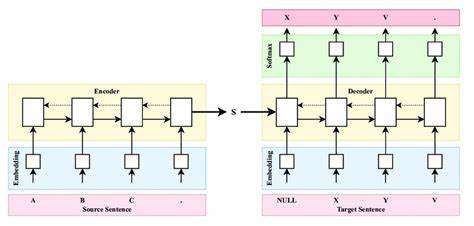

# Example

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sandeepmajumdar_french_english_translated_words_and_phrases_path = kagglehub.dataset_download('sandeepmajumdar/french-english-translated-words-and-phrases')

print('Data source import complete.')


100%|██████████| 6.32M/6.32M [00:00<00:00, 81.7MB/s]

Extracting files...


Data source import complete.


## What is Machine Translation?
Machine translation (MT) refers to fully automated software that can translate source content into target languages. Humans may use MT to help them render text and speech into another language, or the MT software may operate without human intervention.

![image.png](attachment:image.png)

MT tools are often used to translate vast amounts of information involving millions of words that could not possibly be translated the traditional way. The quality of MT output can vary considerably; MT systems require “training” in the desired domain and language pair to increase quality.

Translation companies use MT to augment productivity of their translators, cut costs, and provide post-editing services to clients. MT use by language service providers is growing quickly.

Source: https://www.gala-global.org/what-machine-translation

This notebook is an implementation of the article : https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

## Let's start the process of building a model which translates English to French

In [ ]:
sandeepmajumdar_french_english_translated_words_and_phrases_path

'/root/.cache/kagglehub/datasets/sandeepmajumdar/french-english-translated-words-and-phrases/versions/1'

In [ ]:
ls - /root/.cache/kagglehub/datasets/sandeepmajumdar/french-english-translated-words-and-phrases/versions/1

ls: cannot access '-': No such file or directory
/root/.cache/kagglehub/datasets/sandeepmajumdar/french-english-translated-words-and-phrases/versions/1:
fra.txt


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,LSTM,Dense

batch_size=64
epochs=100
latent_dim=256 # here latent dim represent hidden state or cell state
num_samples=10000

data_path='/root/.cache/kagglehub/datasets/sandeepmajumdar/french-english-translated-words-and-phrases/versions/1/fra.txt'

In [ ]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [ ]:
input_characters=sorted(list(input_characters))
target_characters=sorted(list(target_characters))

num_encoder_tokens=len(input_characters)
num_decoder_tokens=len(target_characters)

max_encoder_seq_length=max([len(txt) for txt in input_texts])
max_decoder_seq_length=max([len(txt) for txt in target_texts])

In [ ]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59


In [ ]:
input_token_index=dict(
    [(char,i) for i, char in enumerate(input_characters)])
target_token_index=dict(
[(char,i) for i, char in enumerate(target_characters)])

In [ ]:
import numpy as np
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [ ]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

## Defining the encoder and decoder

In [ ]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


In [ ]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7032 - loss: 1.5855 - val_accuracy: 0.7076 - val_loss: 1.2269
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7433 - loss: 0.9798 - val_accuracy: 0.7097 - val_loss: 1.0022
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7604 - loss: 0.8678 - val_accuracy: 0.7498 - val_loss: 0.9066
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7857 - loss: 0.7762 - val_accuracy: 0.7655 - val_loss: 0.8188
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8006 - loss: 0.6979 - val_accuracy: 0.7798 - val_loss: 0.7599
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8135 - loss: 0.6476 - val_accuracy: 0.7838 - val_loss: 0.7246
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8199 - loss: 0.6161 - val_accuracy: 0.7886 - val_loss: 0.7241
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8271 - loss: 0.5906 - 

In [ ]:
 model.save('eng2french.h5')

In [ ]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [ ]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
-
Input sentence: Go.
Decoded sentence: Filez !

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
-
Input sentence: Go.
Decoded sentence: Filez !

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0